## Analyze e2e latencies for the single_client_e2e experiment

In [19]:
import re
import numpy as np

def get_results(path):
    computee2e, confirme2e = [], []
    consumee2e = []
    avg_batching_latencies = []
    avg_batch_size = []
    with open(path+"/client_node7.log", "r") as f:
        lines = f.readlines()
        for line in lines:
            if "latencies: " in line:
                consume, confirm, compute = line.strip().split('latencies: ')[-1].split(',')[-3:]
                consumee2e.append(int(consume))
                confirme2e.append(int(confirm))
                computee2e.append(int(compute))
            if "average batch size: " in line:
                avg_batch_size.append(float(line.strip().split()[-1]))
            if "average batching latency: " in line:
                avg_batching_latencies.append(float(line.strip().split()[-1]))

    computee2e = np.array(computee2e, dtype=int)
    confirme2e = np.array(confirme2e, dtype=int)
    consumee2e = np.array(consumee2e, dtype=int)

    temp = np.maximum(computee2e, confirme2e)

    print("results for computation time " + path.split("_")[-1] + " us")
    print("statistic/metric, compute e2e (us), confirm e2e (us), consume e2e (us), total e2e (us)")
    print(f"mean, {np.mean(computee2e):.2f}, {np.mean(confirme2e):.2f}, {np.mean(consumee2e):.2f}, {np.mean(temp):.2f}")
    print(f"std, {np.std(computee2e):.2f}, {np.std(confirme2e):.2f}, {np.std(consumee2e):.2f}, {np.std(temp):.2f}")
    print(f"p50, {np.percentile(computee2e, 50):.2f}, {np.percentile(confirme2e, 50):.2f}, {np.percentile(consumee2e, 50):.2f}, {np.percentile(temp, 50):.2f}")
    print(f"p99, {np.percentile(computee2e, 90):.2f}, {np.percentile(confirme2e, 90):.2f}, {np.percentile(consumee2e, 90):.2f}, {np.percentile(temp, 90):.2f}")

    print("average batch size, average batching latencies")
    print(f"{avg_batch_size[-1]:.2f}, {avg_batching_latencies[-1]:.2f}")

    return np.mean(computee2e), np.mean(confirme2e), np.mean(consumee2e), np.mean(temp)



results for computation time 100 us
statistic/metric, compute e2e (us), confirm e2e (us), consume e2e (us), total e2e (us)
mean, 917.41, 2665.71, 777.03, 2665.71
std, 267.93, 566.87, 259.61, 566.88
p50, 874.00, 2846.00, 731.00, 2846.00
p99, 1073.00, 3157.00, 904.00, 3157.00
average batch size, average batching latencies
1.47, 55.89
****************************
results for computation time 200 us
statistic/metric, compute e2e (us), confirm e2e (us), consume e2e (us), total e2e (us)
mean, 1072.37, 2344.75, 789.41, 2344.76
std, 361.91, 616.91, 351.04, 616.92
p50, 1002.00, 2070.00, 711.00, 2070.00
p99, 1244.00, 3136.00, 896.00, 3136.00
average batch size, average batching latencies
1.47, 35.29
****************************
results for computation time 500 us
statistic/metric, compute e2e (us), confirm e2e (us), consume e2e (us), total e2e (us)
mean, 1526.89, 2373.67, 797.99, 2373.89
std, 399.50, 634.59, 343.57, 634.53
p50, 1517.00, 2086.00, 725.00, 2087.00
p99, 1838.00, 3166.00, 902.00, 316

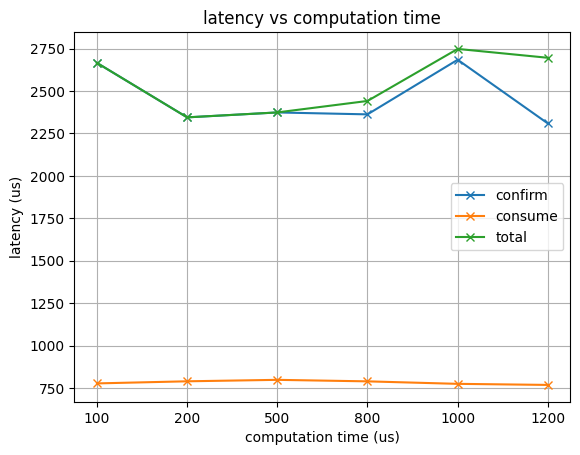

In [21]:
import matplotlib.pyplot as plt
compute = []
confirm = []
consume = []
total = []

comp_times=["100", "200", "500", "800", "1000", "1200"]
for comp_time in comp_times:
    compute_lat, confirm_lat, consume_lat, total_lat = get_results(f"../results/logs/e2e_{comp_time}")
    compute.append(compute_lat)
    confirm.append(confirm_lat)
    consume.append(consume_lat)
    total.append(total_lat)
    print("****************************")


fig, ax = plt.subplots()
ax.plot(comp_times, confirm, label='confirm', marker='x')
ax.plot(comp_times, consume, label='consume', marker='x')
ax.plot(comp_times, total, label='total', marker='x')

ax.set(xlabel='computation time (us)', ylabel='latency (us)', title='latency vs computation time')
ax.grid()
ax.legend()
fig.savefig("latency_vs_comp_time.png", dpi=600)
plt.show()